In [1]:
import numpy as np
from qiskit.transpiler import CouplingMap

from gate_level.spillover_noise_use_case.generic_spillover.generic_spillover_noise import (
    numpy_to_hashable,
)
from generic_spillover_noise import (
    circuit_context,
    noisy_backend,
    SpilloverNoiseAerPass,
)

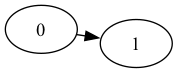

In [2]:
# Define the number of qubits
num_qubits = 2
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

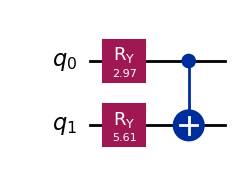

In [3]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits)
# gate_types = ['RY', 'RY', 'RX', 'RX', 'RX', 'RY']
sq_gates = {0: "ry", 1: "ry", 2: "rx", 3: "rx", 4: "rx", 5: "ry"}  # {qubit: gate_type}
sq_gates = {0: "ry", 1: "ry"}  # {qubit: gate_type}
# Create the quantum circuit
qc = circuit_context(
    num_qubits, list(sq_gates.values()), rotation_angles, coupling_map=cm
)

# Display the circuit structure
qc.draw("mpl")

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
# gamma_matrix[0, 3] = 0.025  # γ_0->3
# gamma_matrix[1, 2] = 0.025  # γ_1->2
# gamma_matrix[2, 3] = 0.025  # γ_2->3
# gamma_matrix[3, 2] = 0.025  # γ_3->2
# gamma_matrix[4, 3] = 0.025  # γ_4->3
# gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix

array([[0.   , 0.025],
       [0.   , 0.   ]])

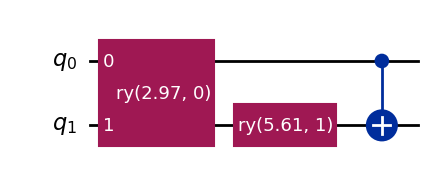

In [5]:
from generic_spillover_noise import SpilloverNoiseAerPass, numpy_to_hashable
from qiskit.transpiler import PassManager

pm = PassManager(
    [SpilloverNoiseAerPass(spillover_rate_matrix=numpy_to_hashable(gamma_matrix))]
)
noisy_qc = pm.run(qc)
noisy_qc.draw("mpl")

In [6]:
from qiskit.quantum_info import Statevector

Statevector(qc).equiv(Statevector(noisy_qc))

True

In [7]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(qc, gamma_matrix)

NoiseError: 'Number of qubits (2) does not match  the error size (1)'

In [8]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'b807afcc1fa842bfaacbab7cc2de4bc0',
   'operations': ['ry(1.02, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[ 0.9999191 +0.j, -0.01271953+0.j],
              [ 0.01271953+0.j,  0.9999191 +0.j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}